In [1]:
import numpy as np
import statsmodels.api as sm
import pickle
import fastparquet
import pandas_datareader as pdr
import requests
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import warnings
from numpy import array
from importlib import reload # to reload modules if we made changes to them without restarting kernel
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier, XGBRegressor # for features importance
from sklearn.metrics import precision_score, recall_score, accuracy_score
import functions
from feature_engineering import get_headlines

warnings.filterwarnings('ignore')
plt.rcParams['figure.dpi'] = 227 # native screen dpi for my computer

### Carregando dados

In [2]:
df = pd.read_parquet('data/eth.parquet')

In [3]:
df.head(3)

,const,close,volume,number_of_trades,target,return,change,volatility,momentum,rsi,macd,signal,upper_band,lower_band,lag_1,lag_2,ma_10,ma_30,ratio_ma,time
open_time,,,,,,,,,,,,,,,,,,,,
2021-01-01 00:49:00,1.0,734.010010,252.489807,246,0.059263,0.0,0.040039,1.409659,730.330017,56.361752,0.279045,0.161656,734.673090,731.536418,0.005455,0.054498,733.502991,732.485659,1.001389,785540
2021-01-01 00:50:00,1.0,734.210022,268.051392,326,0.032959,0.0,0.200012,1.401633,730.609985,57.819760,0.320303,0.193385,734.707639,731.750444,0.027242,0.032695,733.553992,732.634660,1.001255,785541
2021-01-01 00:51:00,1.0,734.190002,198.461334,197,0.025607,-0.0,-0.020020,1.390473,730.969971,57.612274,0.347380,0.224184,734.811543,731.796065,-0.002727,0.024516,733.639990,732.752327,1.001211,785542


### Separando Treino e Teste

In [4]:
test_treshold = '2020-01-01 00:00:00'

train = df[df.index < test_treshold]
test = df[df.index >= test_treshold]

X_train = train.drop(columns=['target'])
y_train = train['target']

X_test = test.drop(columns=['target'])
y_test = test['target']

In [5]:
# Tamanho dos DF
print('Número de observações Treino:', len(train))
print('Número de observações Teste:', len(test))
print('TOTAL:', len(df))

Número de observações Treino: 0
Número de observações Teste: 294536
TOTAL: 294536


## 2.ARIMA

In [11]:
# ARIMA, SARIMA
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from sklearn.metrics import mean_squared_error, confusion_matrix, f1_score, accuracy_score, r2_score, mean_absolute_error
from pandas.plotting import autocorrelation_plot
from pmdarima.arima import auto_arima, ADFTest
from statsmodels.tools.eval_measures import rmse

In [19]:
print('ETH historical data contains {} entries'.format(df.shape[0]))
df[['target']].head()

ETH historical data contains 294536 entries


,target
open_time,
2021-01-01 00:49:00,0.059263
2021-01-01 00:50:00,0.032959
2021-01-01 00:51:00,0.025607
2021-01-01 00:52:00,-0.109513
2021-01-01 00:53:00,-0.026136


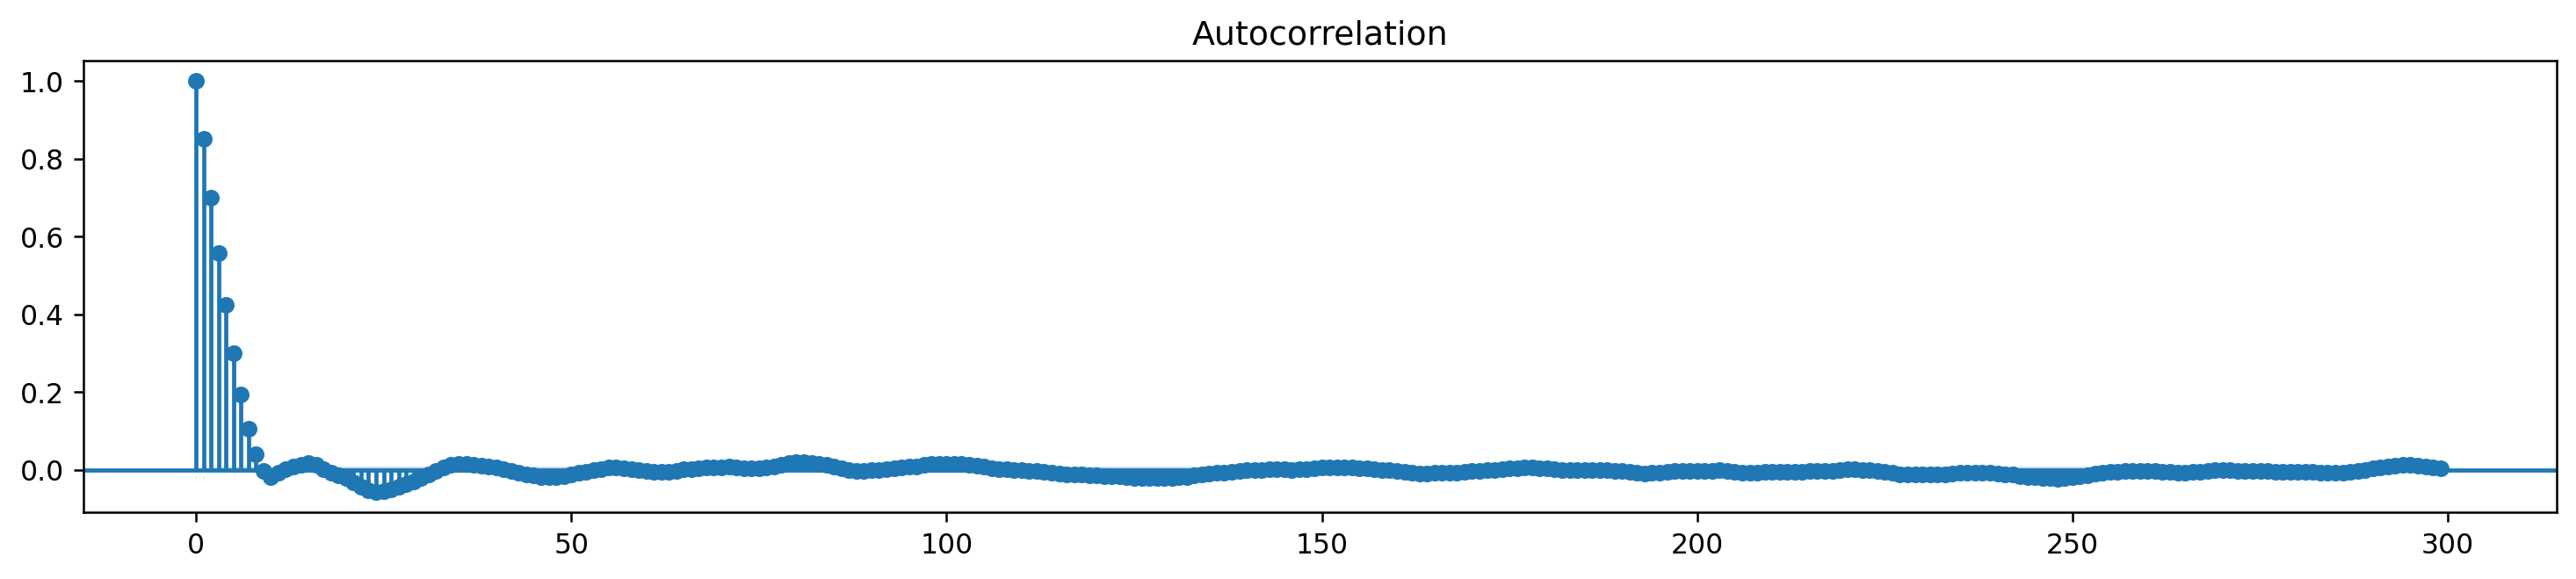

In [10]:
plt.rcParams['figure.figsize'] = (16, 3)
plot_acf(df['target'], lags=range(300))
plt.show()

<AxesSubplot:xlabel='open_time'>

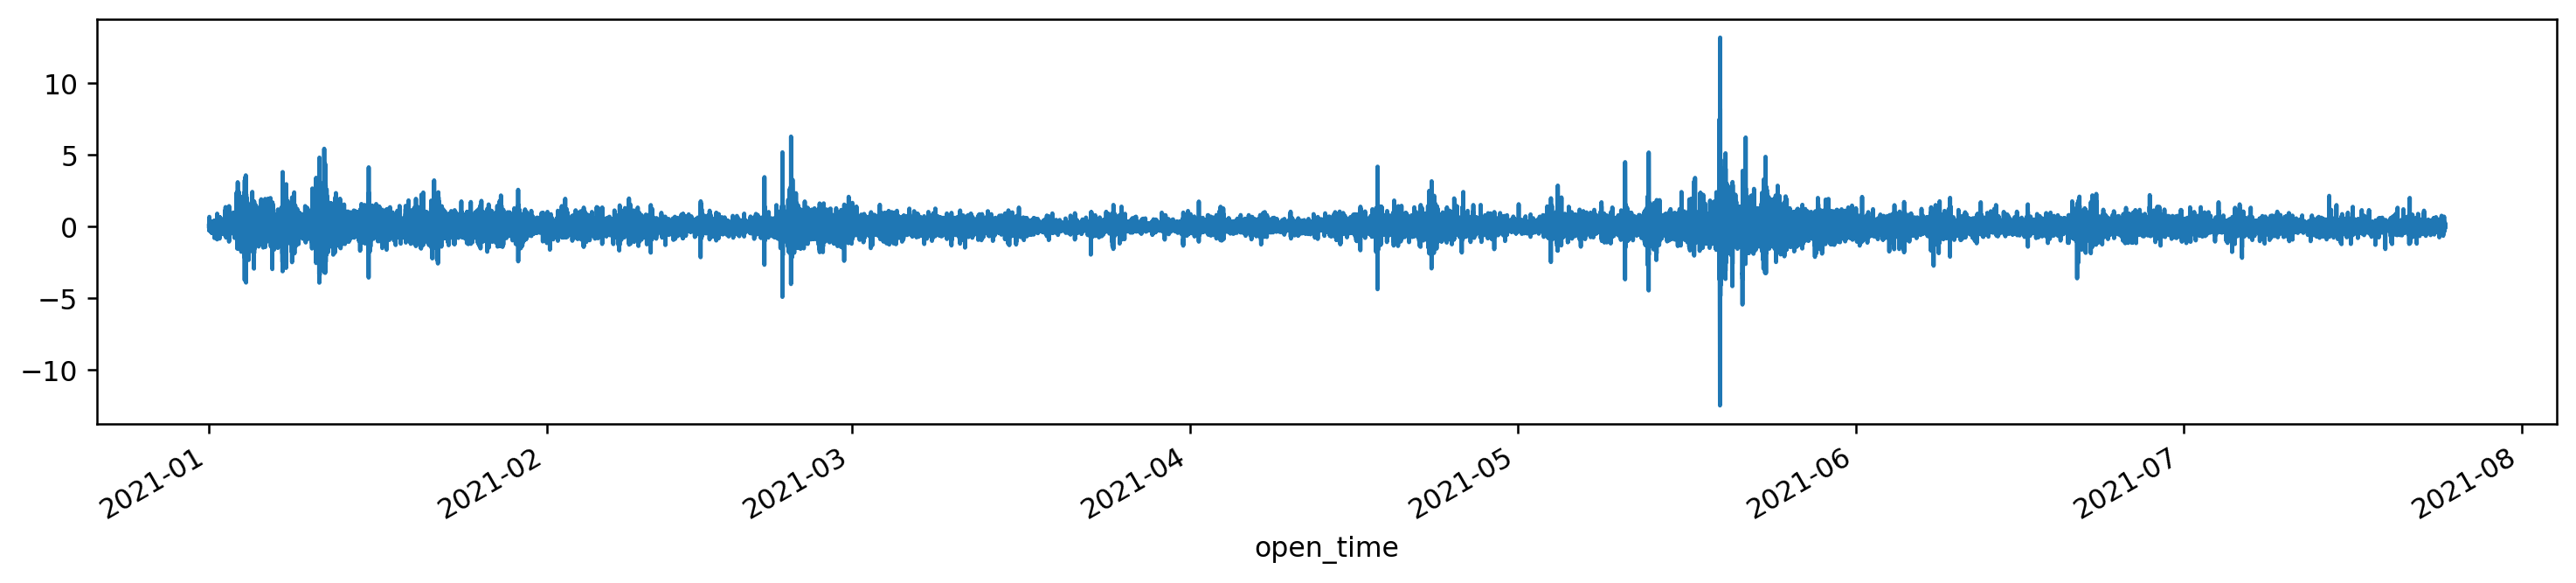

In [11]:
df['target'].plot()

#### Teste de estacionaridade

In [12]:
adf_test = ADFTest(alpha = 0.05)
adf_test.should_diff(df['target'])

(0.01, False)

#### Diminuindo o tamanho da amostra para executar ARIMA

Executado somente com dados de julho 2021 devido capacidade de processamento da máquina.

In [137]:
test_treshold = '2021-07-20 00:00:00'
train_arima = df[df.index < test_treshold]
test_arima = df[df.index >= test_treshold]

X_train = train_arima.drop(columns=['target'])
y_train = train_arima['target']

X_test = test_arima.drop(columns=['target'])
y_test = test_arima['target']

In [138]:
# Tamanho dos DF
print('Número de observações Traino:', len(train_arima))
print('Número de observações Teste:',len(test_arima))

Número de observações Traino: 287346
Número de observações Teste: 7190


#### Divisão Treino e Teste

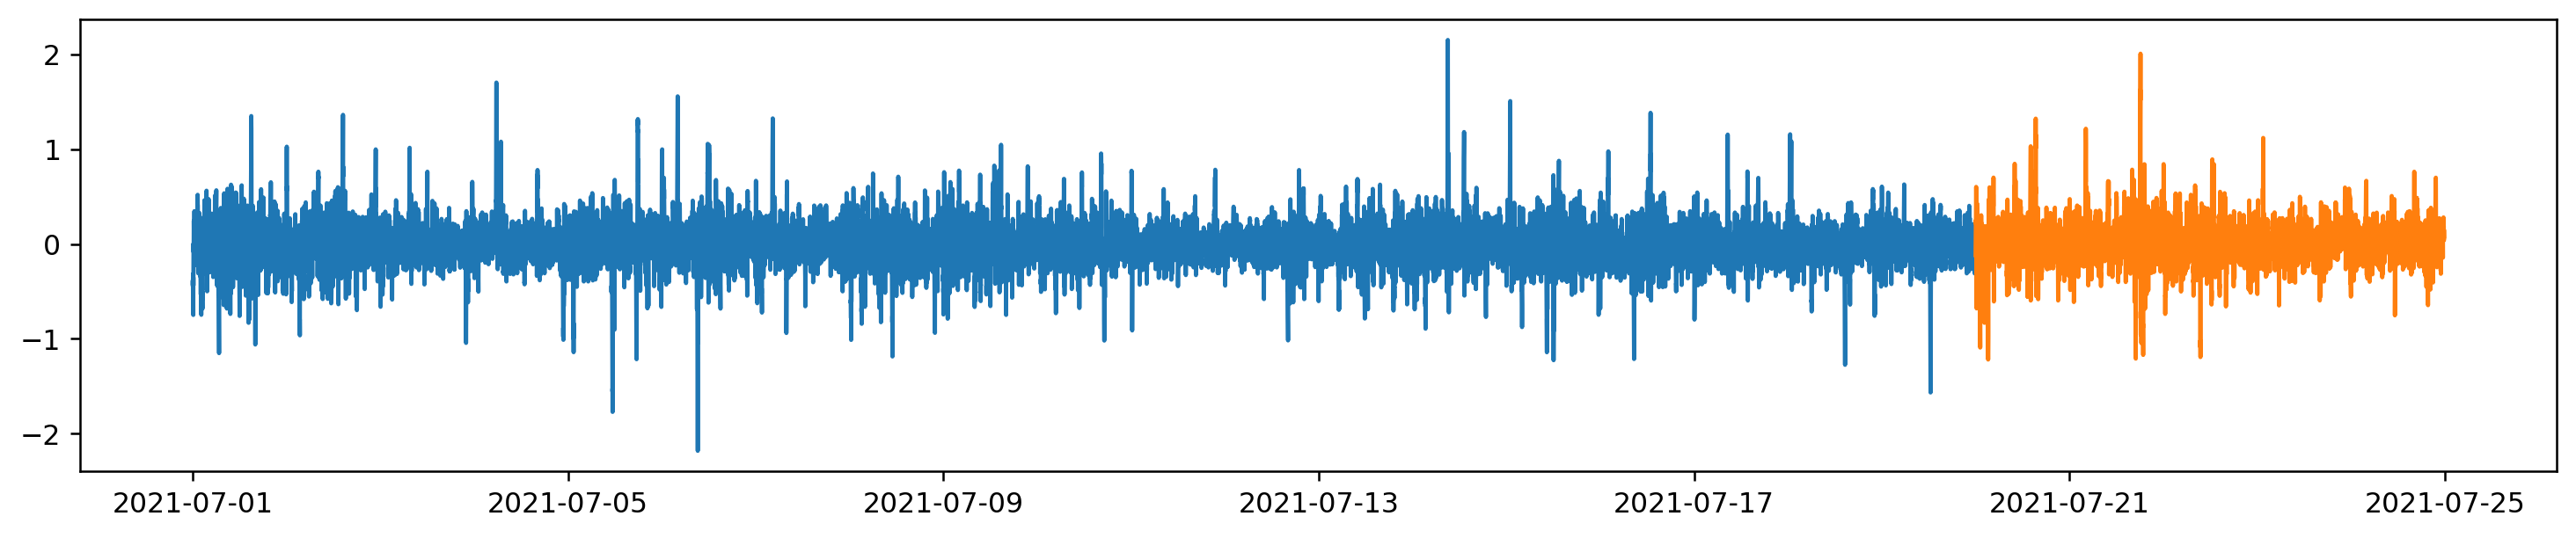

In [26]:
plt.rcParams['figure.figsize'] = (16, 3)
plt.plot(y_train)
plt.plot(y_test)
plt.show()

In [9]:
arima_model = auto_arima(y_train, start_p=0, d=1, start_q=0, 
                         max_p=2, max_d=2, max_q=2,start_P=0,
                         D=1,start_Q=0,max_P=2,max_D=2,max_Q=2,
                         m=12,seasonal=True,erro_action='warn',
                         trace=True,supress_warnings=True,stepwise=True,
                        random_state=20,n_fits=50)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-19336.798, Time=3.26 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-26965.862, Time=6.50 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=34.66 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=-19334.900, Time=1.11 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=-30322.868, Time=16.79 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=164.63 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=52.34 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=-30324.510, Time=12.10 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=-26964.717, Time=8.36 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=117.09 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=64.59 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=-30322.885, Time=16.61 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=-30322.824, Time=31.03 sec
 ARIMA(0,1,0)(2,1,0)[12] intercept   : AIC=-30322.510, Time=82.69 sec

Best model:  

In [10]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                27360
Model:             SARIMAX(0, 1, 0)x(2, 1, 0, 12)   Log Likelihood               15165.255
Date:                            Wed, 13 Oct 2021   AIC                         -30324.510
Time:                                    20:34:03   BIC                         -30299.860
Sample:                                         0   HQIC                        -30316.566
                                          - 27360                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.6614      0.004   -151.046      0.000      -0.670      -0.653
ar.S.L24      -0.3401      0.004    -77.954      0.000      -0.349      -0.332
sigma2         0.0193   9.72e-05    198.689      0.000       0.019       0.019
===================================================================================
Ljung-Box (L1) (Q):                   0.36   Jarque-Bera (JB):             16276.09
Prob(Q):                              0.55   Prob(JB):                         0.00
Heteroskedasticity (H):               0.83   Skew:                            -0.05
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.78
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [11]:
model = SARIMAX(y_train,order=(0,1,0),seasonal_order=(2,1,0,12))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                             target   No. Observations:                27360
Model:             SARIMAX(0, 1, 0)x(2, 1, 0, 12)   Log Likelihood               15165.255
Date:                            Wed, 13 Oct 2021   AIC                         -30324.510
Time:                                    20:34:23   BIC                         -30299.860
Sample:                                07-01-2021   HQIC                        -30316.566
                                     - 07-19-2021                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.6614      0.004   -151.046      0.000      -0.670      -0.653
ar.S.L24      -0.3401      0.004    -77.954      0.000      -0.349      -0.332
sigma2         0.0193   9.72e-05    198.689      0.000       0.019       0.019
===================================================================================
Ljung-Box (L1) (Q):                   0.36   Jarque-Bera (JB):             16276.09
Prob(Q):                              0.55   Prob(JB):                         0.00
Heteroskedasticity (H):               0.83   Skew:                            -0.05
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.78
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Realizando a previsão

In [29]:
previsao_arima = pd.DataFrame(arima_model.predict(n_periods = 7190),index=y_test.index)
previsao_arima.columns = ['Forecast_ARIMA']
previsao_arima

,Forecast_ARIMA
open_time,
2021-07-20 00:00:00,-0.065158
2021-07-20 00:01:00,-0.065983
2021-07-20 00:02:00,-0.085684
2021-07-20 00:03:00,-0.121969
2021-07-20 00:04:00,-0.098705
...,...
2021-07-24 23:45:00,-25.352427
2021-07-24 23:46:00,-25.362845
2021-07-24 23:47:00,-25.459929


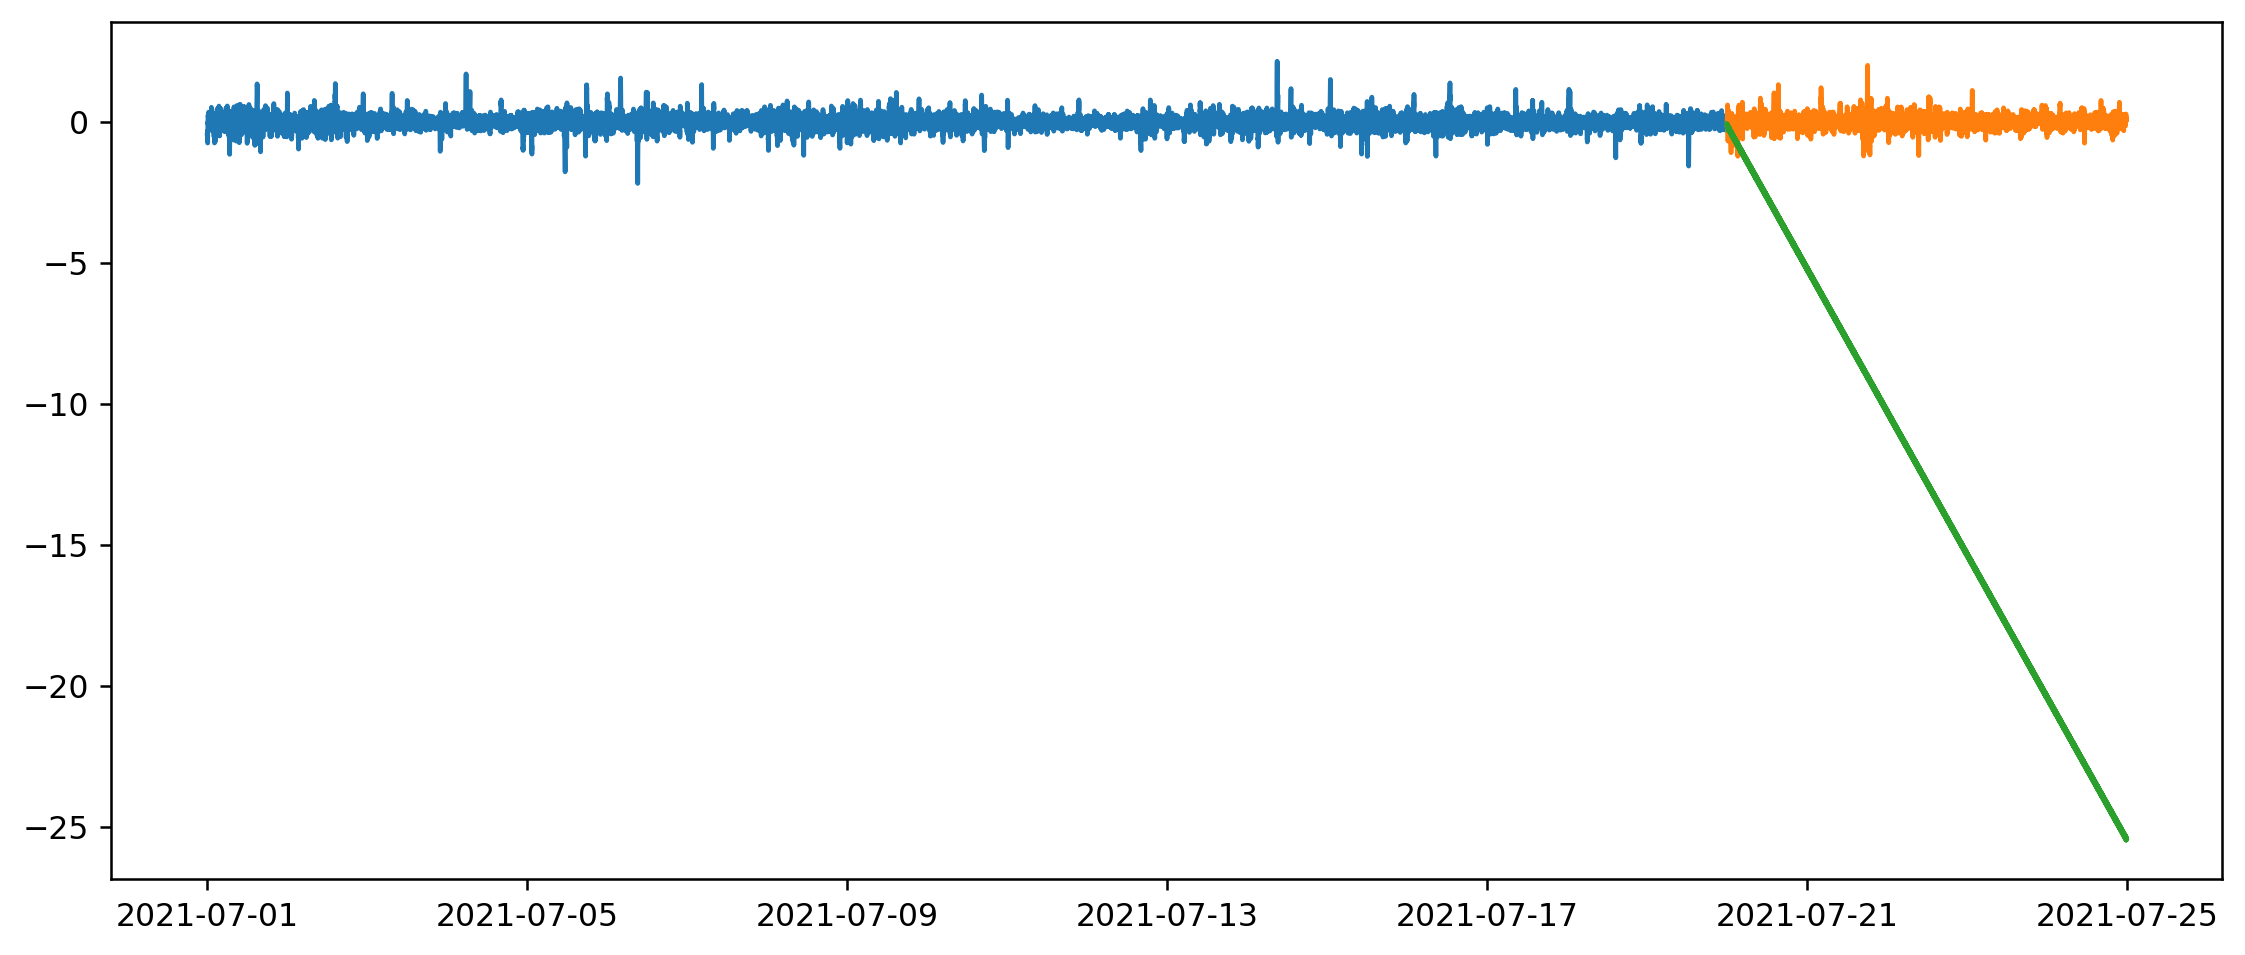

In [13]:
plt.figure(figsize=(12,5))
plt.plot(y_train, label="Treino")
plt.plot(y_test, label="Teste")
plt.plot(previsao_arima, label="Previsão")
plt.show()

#### Resultado do ARIMA

In [28]:
MAE = mean_absolute_error(y_test, previsao_arima)
RMSE = np.sqrt(mean_squared_error(y_test, previsao_arima))
R2 = r2_score(y_test, previsao_arima)
MSE = mean_squared_error(y_test, previsao_arima)

print(f"MAE : {MAE}")
print(f"RMSE : {RMSE}")
print(f"R2 : {R2}")
print(f"MSE : {MSE}")

MAE : 12.789093457419114
RMSE : 14.72828902076177
R2 : -4405.3970920857255
MSE : 216.92249747909167
